Mostly following
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html<br>
https://github.com/AKASHKADEL/dcgan-mnist

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

Generator & Discriminator classes

In [18]:
class Discriminator(nn.Module):
    def __init__(self, num_feature_maps, num_color_channels):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(

            nn.Conv2d(num_color_channels, num_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

class Generator(nn.Module):
    def __init__(self, size_z, num_feature_maps, num_color_channels):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(size_z, num_feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps*4, num_feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps, num_color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.network(input)
        return output

Check if GPU is available. If so activate

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Transform image data to tensor and normalize.<br>
Normalization: output = (input - mean) / std

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5,), std=(.5,))
])

Load MNIST Training-Data

In [ ]:
train_dataset = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=False,
)

# Exclude 3s
indices = \
          (train_dataset.targets == 1) |\
          (train_dataset.targets == 2) |\
          (train_dataset.targets == 4) |\
          (train_dataset.targets == 5) |\
          (train_dataset.targets == 6) |\
          (train_dataset.targets == 7) |\
          (train_dataset.targets == 8) |\
          (train_dataset.targets == 9)
train_dataset.data, train_dataset.targets = train_dataset.data[indices], train_dataset.targets[indices]

Set various hyper-parameter

In [ ]:
batch_size = 128
num_classes = 10
learning_rate = 0.002
num_epochs = 1
num_color_channels = 1
num_feature_maps_g = 32
num_feature_maps_d = 32
size_z = 100
adam_beta1 = 0.2
num_gpu = 0

Load data into dataloader, create generator, discriminator objects and loss function

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

Plot some data

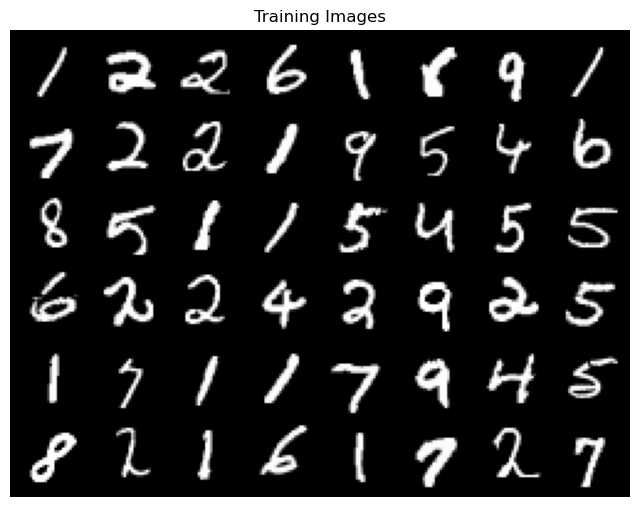

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:48], padding=3, normalize=True).cpu(),(1,2,0)))


In [ ]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)

In [ ]:
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

In [ ]:
criterion = nn.BCELoss()

Generate fixed noise for final image generation. Create Adam optimizer objects

In [ ]:
fixed_noise = torch.randn(64, size_z, 1, 1, device=device)

In [ ]:
real_label = 1.
fake_label = 0.

In [ ]:
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))

Training Loop

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

In [ ]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # get batch-size from actual image batch
        bs = real_images.shape[0]

        # -- train discriminator --

        # reset/clear discriminators gradient
        discriminator.zero_grad()

        # move images to either CPU or GPU
        real_images = real_images.to(device)

        # creates a label tensor filled with 1s
        label = torch.full((bs,), real_label, device=device)

        # get probs for discriminators guess on the real images
        output = discriminator(real_images)

        # get loss for real images. that means it calculates the difference
        # between the output of the model with the current parameter and the
        # target (goal) of what the model is supposed to do
        # output --> current outcome of the model
        # label  --> target of the model
        lossD_real = criterion(output, label)

        # calculates the gradient (using chain-rule)
        # see https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
        lossD_real.backward()

        # Gets the mean value of all results from the discriminator to get an average
        # probability of all sample evaluations (for real data ) --> D(x)
        D_x = output.mean().item()

        # create noise as an input for the G in order to create fake images
        noise = torch.randn(bs, size_z, 1, 1, device=device)

        # use generator to map input noise to an output that is supposed do become fake images during training
        fake_images = generator(noise)

        # creates a label tensor filled with 0s
        label.fill_(fake_label)

        # get discriminators guess on fake images
        output = discriminator(fake_images.detach())

        # get loss for fake images
        lossD_fake = criterion(output, label)

        # adjust parameter to identify fakes
        lossD_fake.backward()

        # gets the mean value of all results from the discriminator to get an average
        # probability of all sample evaluations. this time for the fake images that were
        # generated by the generator --> D(G(z))
        D_G_z1 = output.mean().item()

        # calculate loss
        lossD = lossD_real + lossD_fake

        # adjust models (discriminator) parameter
        optimizerD.step()

        # -- train generator --

        # reset/clear generators gradient
        generator.zero_grad()

        # creates a label tensor filled with 1s
        label.fill_(real_label)

        # get discriminators guess on fake images
        output = discriminator(fake_images)

        # get loss for fake images
        lossG = criterion(output, label)

        # adjust parameter to generate fakes
        lossG.backward()

        # gets the mean value of all results from the discriminator to get an average
        # probability of all sample evaluations. this time for the fake images that were
        # generated by the generator --> D(G(z))
        D_G_z2 = output.mean().item()

        # adjust models (generator) parameter
        optimizerG.step()
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

Starting Training Loop...
[0/1][0/375]	Loss_D: 1.4208	Loss_G: 2.5759	D(x): 0.5650	D(G(z)): 0.5605 / 0.0808
[0/1][100/375]	Loss_D: 1.0677	Loss_G: 0.9969	D(x): 0.5605	D(G(z)): 0.3734 / 0.3758
[0/1][200/375]	Loss_D: 1.1656	Loss_G: 1.6366	D(x): 0.7181	D(G(z)): 0.5514 / 0.2075
[0/1][300/375]	Loss_D: 1.8953	Loss_G: 0.2362	D(x): 0.1997	D(G(z)): 0.1674 / 0.7939


Save models

In [34]:
torch.save(generator.state_dict(),'./saved_models/generator.pkl')
torch.save(discriminator.state_dict(),'./saved_models/discriminator.pkl')

Plot losses of both, generator and discriminator

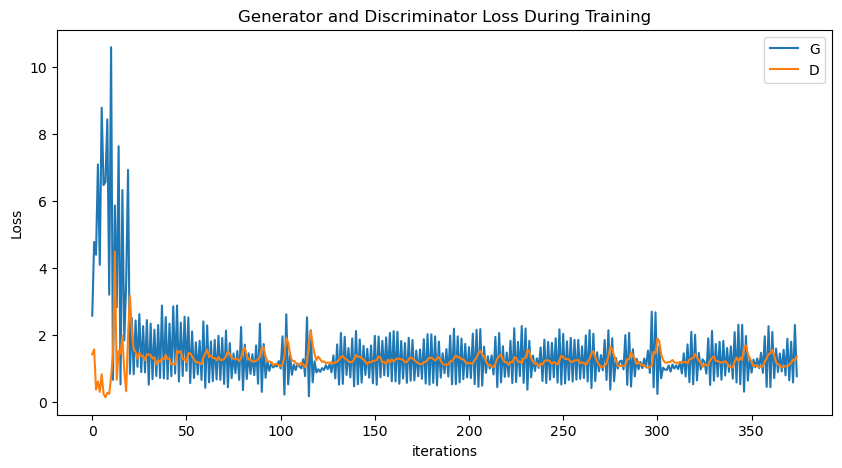

In [35]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Generate animation

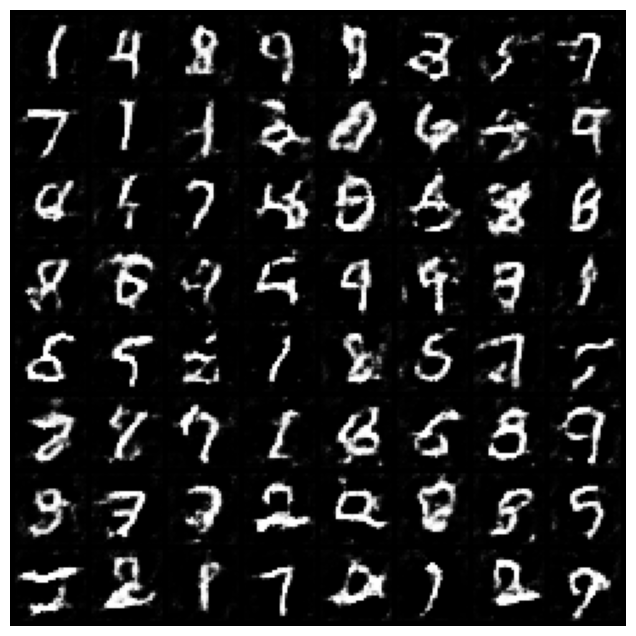

In [36]:
plt.rcParams['animation.embed_limit'] = 100
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())